In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import StandardScaler


seed = 331

In [71]:
def resultPlot(x_name, x, fnr, fpr, roc_auc, sensitivities, specificities, scale=1, marker=None):
    fig = plt.figure(figsize = (5, 5))
    
    colors = ['r', 'g', 'b', 'c', 'm']

    plt.plot(x, fnr, color=colors[0], marker=marker, label ='FNR')
    plt.plot(x, fpr, color=colors[1], marker=marker, label ='FPR')
    plt.plot(x, roc_auc, color=colors[2], marker=marker, label ='ROC AUC')
    plt.plot(x, sensitivities, color=colors[3], marker=marker, label ='Sensitivity')
    plt.plot(x, specificities, color=colors[4], marker=marker, label ='Specificity')

    # # Adding Xticks
    plt.xlabel(x_name, fontweight ='bold', fontsize = 15)
    plt.ylabel('Value', fontweight ='bold', fontsize = 15)
    if scale > 1:
        plt.xticks([x[i] for i in range(0,len(x),scale)])
    else:
        plt.xticks(x)

    plt.grid()
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.)
    plt.show()

In [3]:
def fnr_calc(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    return fn / (fn + tp)

def fpr_calc(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    return fp / (fp + tn)



def model_metrics(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred, labels=[1,0]).ravel()
    
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tp + tn)
    
    return fnr, fpr, roc_auc, sensitivity, specificity

# Data preparation

In [4]:
dataframe = pd.read_csv("./data/creditcard.csv")

columns = dataframe.columns.drop('Class')

dataframe.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
scaled_dataframe = dataframe.copy().drop(['Class'],axis=1)

transformer = StandardScaler()

transformer.fit(scaled_dataframe)

scaled_dataframe = transformer.transform(scaled_dataframe)
scaled_dataframe = pd.DataFrame(scaled_dataframe, columns=columns)

In [6]:
X = scaled_dataframe
y = dataframe.Class

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed, test_size=0.33)

print("train rows: {}, test rows: {}".format(X_train.shape[0], X_test.shape[0]))

train rows: 190820, test rows: 93987


# Testing LDA classifier

In [7]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

lda.score(X_test, y_test)

0.9995318501494888

In [8]:
y_pred = lda.predict(X_test)

In [9]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
cm

array([[  128,    29],
       [   15, 93815]], dtype=int64)

In [10]:
fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr * 100, fpr * 100))
print("ROC AUC = {:.4f}".format(roc_auc * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity * 100, specificity * 100))

FNR = 18.4713%, FPR = 0.0160%
ROC AUC = 90.7563
sensitivity = 81.5287%, specificity = 99.8637%


## Testing other LDA settings

In [11]:
solvers = ['svd', 'lsqr', 'eigen']

fnrs_1 = []
fprs_1 = []
roc_aucs_1 = []
sensitivities_1 = []
specificities_1 = []

for solver in solvers:
    lda = LinearDiscriminantAnalysis(solver=solver)
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_1.append(fnr)
    fprs_1.append(fpr)
    roc_aucs_1.append(roc_auc)
    sensitivities_1.append(sensitivity)
    specificities_1.append(specificity)
    print(fnr, fpr, roc_auc, sensitivity, specificity)



0.18471337579617833 0.00015986358307577535 0.907563380310373 0.8152866242038217 0.998637471658346
0.18471337579617833 0.00015986358307577535 0.907563380310373 0.8152866242038217 0.998637471658346
0.18471337579617833 0.00015986358307577535 0.907563380310373 0.8152866242038217 0.998637471658346


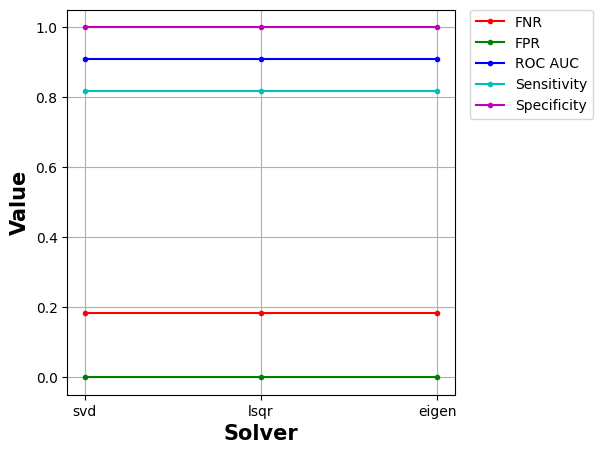

In [37]:
resultPlot('Solver', solvers, fnrs_1, fprs_1, roc_aucs_1, sensitivities_1, specificities_1)

In [55]:
shrinkage = np.arange(0, 1, 0.01)

fnrs = []
fprs = []
roc_aucs = []
sensitivities = []
specificities = []

for shr in shrinkage:
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shr)
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs.append(fnr)
    fprs.append(fpr)
    roc_aucs.append(roc_auc)
    sensitivities.append(sensitivity)
    specificities.append(specificity)


In [56]:
min_fnr = 100
best_shrinkage = 0
for i in range(len(fnrs)):
    if (fprs[i] * 100 < 0.5 and fnrs[i] < min_fnr):
        min_fnr = fnrs[i]
        best_shrinkage = i
        
print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnrs[best_shrinkage] * 100, fprs[best_shrinkage] * 100))
print("ROC AUC = {:.4f}".format(roc_aucs[best_shrinkage] * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivities[best_shrinkage] * 100, specificities[best_shrinkage] * 100))

print("Best shrinkage = {:.2f}".format(shrinkage[best_shrinkage]))

best_shr = shrinkage[best_shrinkage]

FNR = 18.4713%, FPR = 0.0160%
ROC AUC = 90.7563
sensitivity = 81.5287%, specificity = 99.8637%
Best shrinkage = 0.00


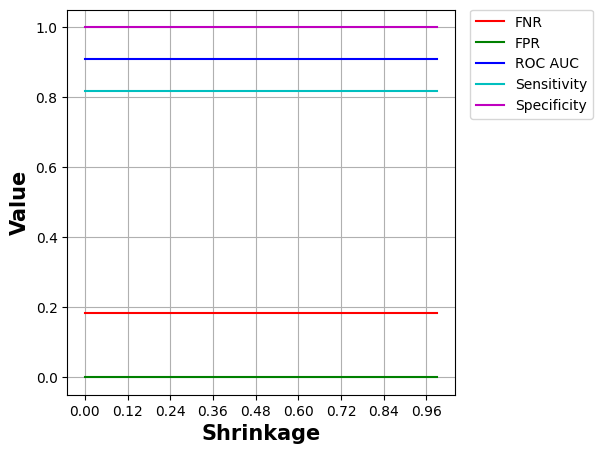

In [79]:
resultPlot('Shrinkage', shrinkage, fnrs, fprs, roc_aucs, sensitivities, specificities, scale=12)

In [58]:
shrinkage = np.arange(0, 1.01, 0.01)

fnrs_2 = []
fprs_2 = []
roc_aucs_2 = []
sensitivities_2 = []
specificities_2 = []

for shr in shrinkage:
    lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage=shr)
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    fnr, fpr, roc_auc, sensitivity, specificity = model_metrics(y_test, y_pred)
    fnrs_2.append(fnr)
    fprs_2.append(fpr)
    roc_aucs_2.append(roc_auc)
    sensitivities_2.append(sensitivity)
    specificities_2.append(specificity)

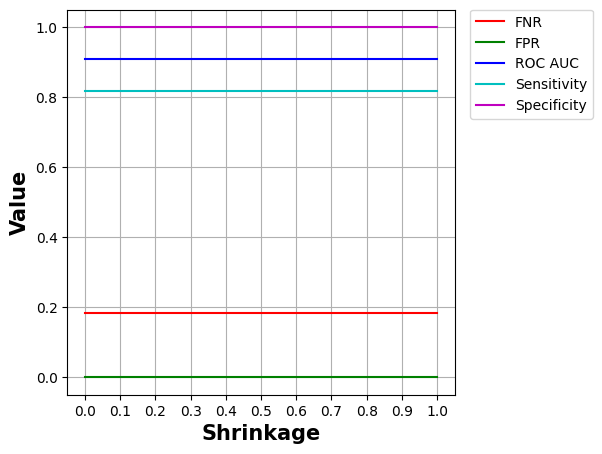

In [81]:
resultPlot('Shrinkage', shrinkage, fnrs_2, fprs_2, roc_aucs_2, sensitivities_2, specificities_2, scale=10)

#  Balancing Classes

### Random under-sampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
undersampled_0_dataframe = RandomUnderSampler(random_state=seed).fit_resample(X_train, y_train)

X_train_und, y_train_und = undersampled_0_dataframe

print(y_train_und.value_counts())

0    335
1    335
Name: Class, dtype: int64


In [20]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_shr)
lda.fit(X_train_und, y_train_und)

y_pred_und = lda.predict(X_test)


cm = confusion_matrix(y_test, y_pred_und, labels=[1,0])
cm

array([[  138,    19],
       [ 2657, 91173]], dtype=int64)

In [21]:
fnr_und, fpr_und, roc_auc_und, sensitivity_und, specificity_und = model_metrics(y_test, y_pred_und)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_und * 100, fpr_und * 100))
print("ROC AUC = {:.4f}".format(roc_auc_und * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_und * 100, specificity_und * 100))

FNR = 12.1019%, FPR = 2.8317%
ROC AUC = 92.5332
sensitivity = 87.8981%, specificity = 99.8489%


### Conclusions
FPR over threshold 0.5%

### Random over-sampling

In [22]:
from imblearn.over_sampling  import RandomOverSampler


In [23]:
oversampled_1_dataframe = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)

X_train_ov, y_train_ov = oversampled_1_dataframe

print(y_train_ov.value_counts())

0    190485
1    190485
Name: Class, dtype: int64


In [24]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_shr)
lda.fit(X_train_ov, y_train_ov)

y_pred_ov = lda.predict(X_test)


cm = confusion_matrix(y_test, y_pred_ov, labels=[1,0])
cm

array([[  138,    19],
       [ 1671, 92159]], dtype=int64)

In [25]:
fnr_ov, fpr_ov, roc_auc_ov, sensitivity_ov, specificity_ov = model_metrics(y_test, y_pred_ov)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_ov * 100, fpr_ov * 100))
print("ROC AUC = {:.4f}".format(roc_auc_ov * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_ov * 100, specificity_ov * 100))

FNR = 12.1019%, FPR = 1.7809%
ROC AUC = 93.0586
sensitivity = 87.8981%, specificity = 99.8505%


### Conclusions


### Smote

In [26]:
from imblearn.over_sampling import  SMOTE

In [27]:
oversampled_0_SMOTE_dataframe = SMOTE(random_state=seed).fit_resample(X_train, y_train)

X_train_ov_SMOTE, y_train_ov_SMOTE = oversampled_0_SMOTE_dataframe

print(y_train_ov_SMOTE.value_counts())

0    190485
1    190485
Name: Class, dtype: int64


In [28]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_shr)
lda.fit(X_train_ov_SMOTE, y_train_ov_SMOTE)

y_pred_ov_SMOTE = lda.predict(X_test)


cm = confusion_matrix(y_test, y_pred_ov_SMOTE, labels=[1,0])
cm

array([[  138,    19],
       [ 1561, 92269]], dtype=int64)

In [29]:
fnr_ov_SMOTE, fpr_ov_SMOTE, roc_auc_ov_SMOTE, sensitivity_ov_SMOTE, specificity_ov_SMOTE = model_metrics(y_test, y_pred_ov_SMOTE)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_ov_SMOTE * 100, fpr_ov_SMOTE * 100))
print("ROC AUC = {:.4f}".format(roc_auc_ov_SMOTE * 100))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_ov_SMOTE * 100, specificity_ov_SMOTE * 100))

FNR = 12.1019%, FPR = 1.6636%
ROC AUC = 93.1172
sensitivity = 87.8981%, specificity = 99.8507%


### Conclusions


### Cluster Centroids

In [60]:
from imblearn.under_sampling import ClusterCentroids

In [61]:
oversampled_ClusterCentroids_dataframe = ClusterCentroids(random_state=seed).fit_resample(X_train, y_train)

X_train_ov_ClusterCentroids, y_train_ov_ClusterCentroids = oversampled_ClusterCentroids_dataframe

print(y_train_ov_SMOTETomek.value_counts())

E:\Projekty\AiED\Projekt\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    190485
1    190485
Name: Class, dtype: int64


In [62]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=best_shr)
lda.fit(X_train_ov_ClusterCentroids, y_train_ov_ClusterCentroids)

y_pred_ov_ClusterCentroids = lda.predict(X_test)


cm = confusion_matrix(y_test, y_pred_ov_ClusterCentroids, labels=[1,0])
cm

array([[  133,    24],
       [ 3038, 90792]], dtype=int64)

In [63]:
fnr_ov_ClusterCentroids, fpr_ov_ClusterCentroids, roc_auc_ov_ClusterCentroids, sensitivity_ov_ClusterCentroids, specificity_ov_ClusterCentroids = model_metrics(y_test, y_pred_ov_ClusterCentroids)

print("FNR = {:.4f}%, FPR = {:.4f}%".format(fnr_ov_ClusterCentroids * 100, fpr_ov_ClusterCentroids * 100))
print("ROC AUC = {:.4f}".format(roc_auc_ov_ClusterCentroids))
print("sensitivity = {:.4f}%, specificity = {:.4f}%".format(sensitivity_ov_ClusterCentroids * 100, specificity_ov_ClusterCentroids * 100))

FNR = 15.2866%, FPR = 3.2378%
ROC AUC = 0.9074
sensitivity = 84.7134%, specificity = 99.8537%
